### Обучить сиамскую сеть для верификации лиц на датасете LFW

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import imageio
import tensorflow as tf
import tensorflow_datasets as tfds
%matplotlib inline

In [84]:
# Ну, для большого датасета слобоват комп, поэтому возьмем датасет поменьше
(train, test), info = tfds.load('lfw', as_supervised=True, with_info=True, download=True, split=['train[:20%]', 'train[80%:]'])

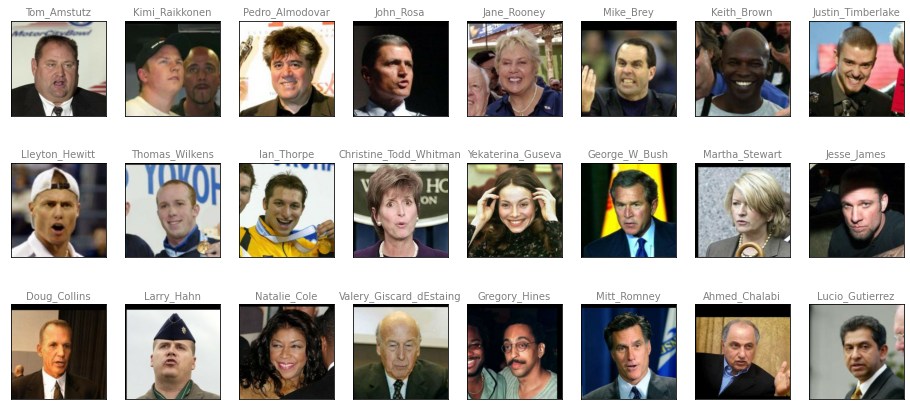

In [3]:
samples = [(x[0], x[1]) for x in iter(train.take(24))]
fig = plt.figure(figsize=(16,10))
for i in range(len(samples)):
    ax = fig.add_subplot(4, 8, i+1)
    ax.imshow(samples[i][1])
    plt.title(samples[i][0].numpy().decode("utf-8"), color='grey', fontsize=10)
    plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
samples[0][1].shape

TensorShape([250, 250, 3])

In [102]:
# Network Parameters
INPUT_DIM = 300
NUM_EPOCHS = 100
HALF_BATCH_SIZE = 32
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0003

In [7]:
train.take(1)

<TakeDataset shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

In [96]:
samples = [(x[0], x[1]) for x in iter(train.take(len(train)))]
x_train, y_train = [], []
for i in range(len(samples)):
    x_train.append(tf.image.resize(samples[i][1], size=(54, 54)))
    y_train.append(samples[i][0].numpy().decode("utf-8"))
    
x_train = (np.array(x_train).astype(np.float32) - 127.5) / 127.5
y_train = np.array(y_train)
x_train.shape, y_train.shape

((2647, 54, 54, 3), (2647,))

In [103]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(3, (3, 3), padding='valid', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [104]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [99]:
def plot_pics(samples):
    fig = plt.figure(figsize=(16, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow((samples[j, ...].reshape(54, 54, 3) * 127.5 + 127.5).astype('uint8'))
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.7351; G Loss: 0.7012


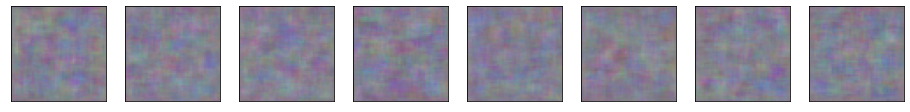

[Step 200] D Loss: 0.6600; G Loss: 3.4255


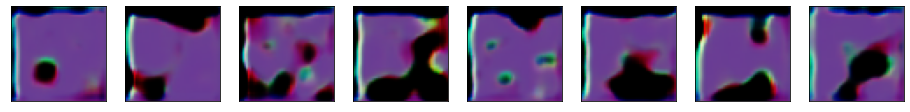

[Step 400] D Loss: 0.0051; G Loss: 6.9669


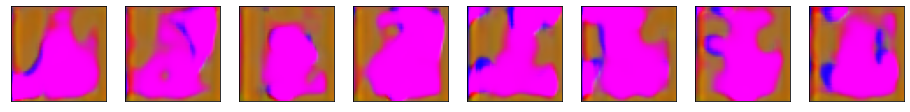

[Step 600] D Loss: 0.1669; G Loss: 10.4257


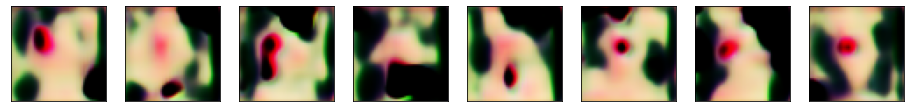

[Step 800] D Loss: 0.5568; G Loss: 2.0404


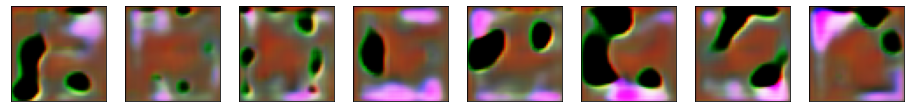

[Step 1000] D Loss: 0.0017; G Loss: 12.5135


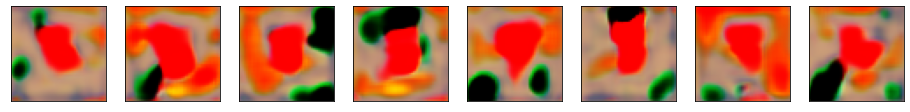

[Step 1200] D Loss: 0.3363; G Loss: 2.5378


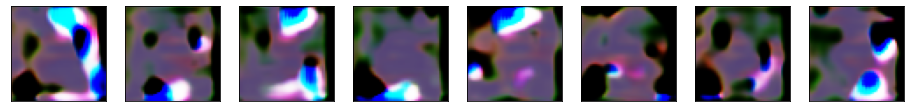

[Step 1400] D Loss: 0.3530; G Loss: 5.8734


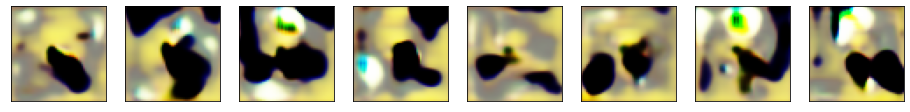

[Step 1600] D Loss: 0.0103; G Loss: 7.8082


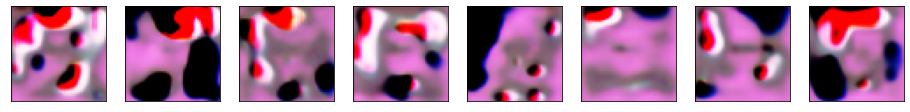

[Step 1800] D Loss: 0.2744; G Loss: 1.5213


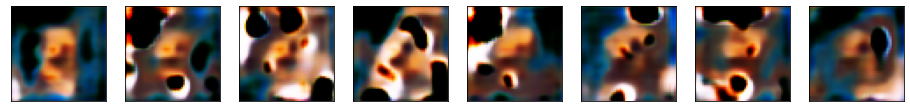

[Step 2000] D Loss: 0.4647; G Loss: 4.2400


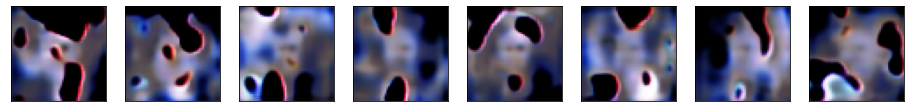

[Step 2200] D Loss: 0.3919; G Loss: 1.3383


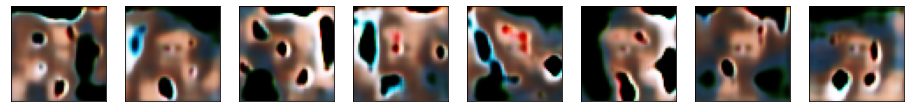

[Step 2400] D Loss: 0.1641; G Loss: 3.6217


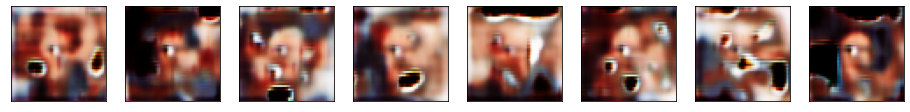

[Step 2600] D Loss: 0.0336; G Loss: 4.5529


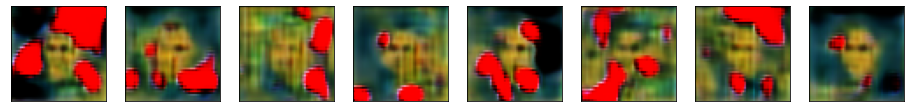

[Step 2800] D Loss: 0.2150; G Loss: 5.6131


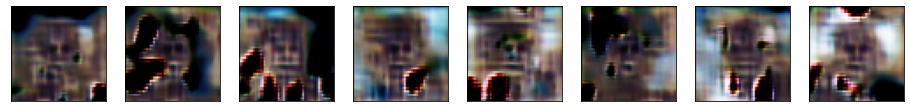

[Step 3000] D Loss: 0.1061; G Loss: 7.1782


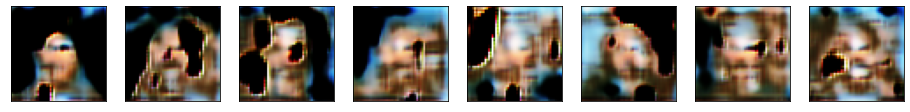

[Step 3200] D Loss: 0.1220; G Loss: 4.9050


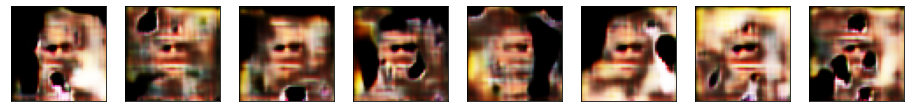

[Step 3400] D Loss: 0.1220; G Loss: 4.7055


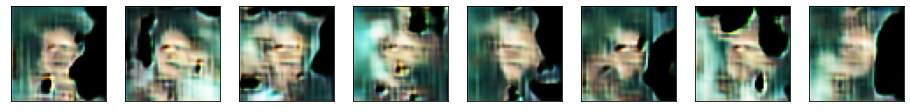

[Step 3600] D Loss: 0.1586; G Loss: 10.0905


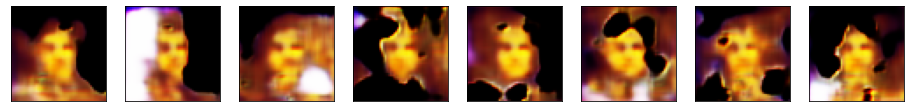

[Step 3800] D Loss: 0.9137; G Loss: 1.4776


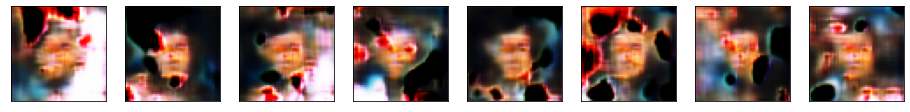

[Step 4000] D Loss: 0.4279; G Loss: 4.6646


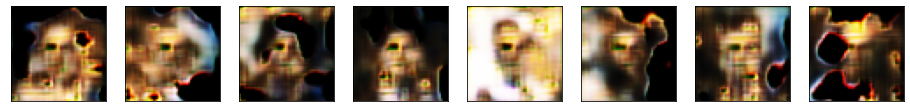

[Step 4200] D Loss: 0.1328; G Loss: 1.8082


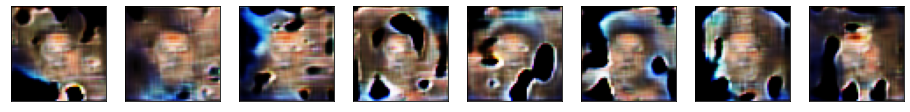

[Step 4400] D Loss: 0.2593; G Loss: 4.0025


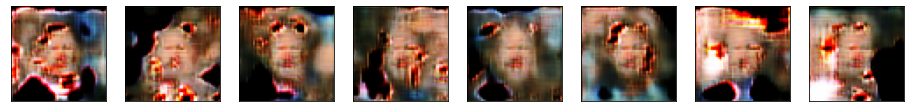

[Step 4600] D Loss: 0.0824; G Loss: 5.3264


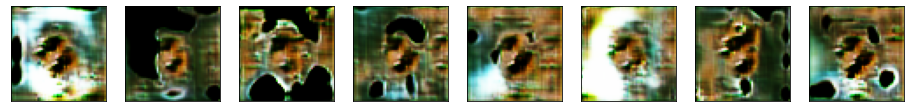

[Step 4800] D Loss: 0.3884; G Loss: 2.9655


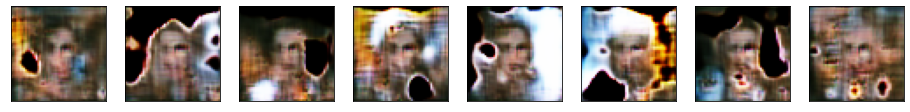

[Step 5000] D Loss: 0.1334; G Loss: 2.8679


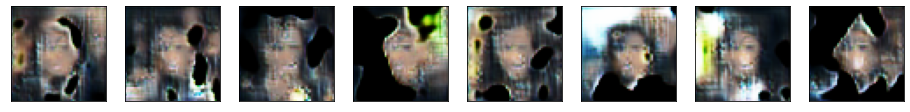

[Step 5200] D Loss: 0.1512; G Loss: 5.3513


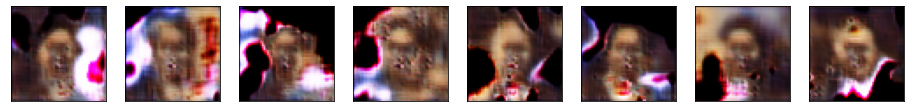

[Step 5400] D Loss: 0.4319; G Loss: 2.4334


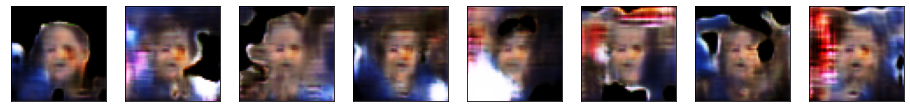

[Step 5600] D Loss: 0.2411; G Loss: 5.7757


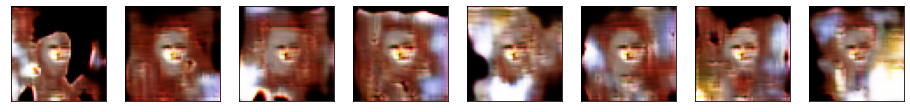

[Step 5800] D Loss: 0.0258; G Loss: 6.7415


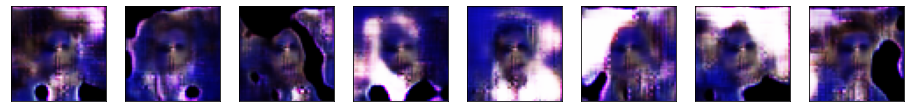

[Step 6000] D Loss: 0.4108; G Loss: 1.4211


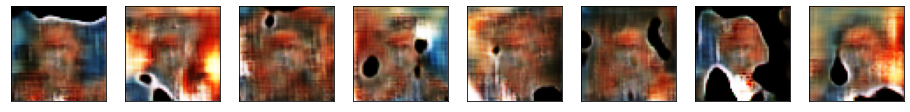

[Step 6200] D Loss: 0.2586; G Loss: 5.4960


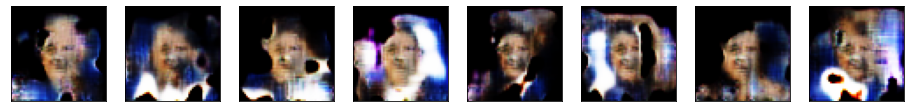

[Step 6400] D Loss: 0.0755; G Loss: 5.7112


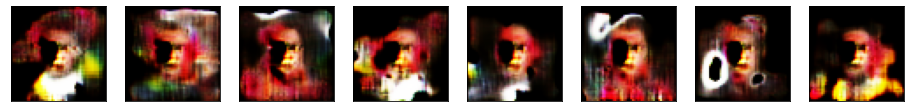

[Step 6600] D Loss: 0.2784; G Loss: 2.5823


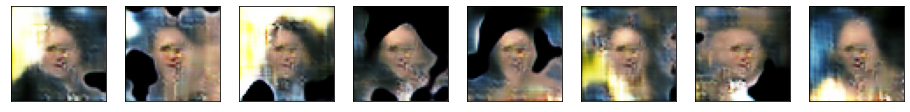

[Step 6800] D Loss: 0.2258; G Loss: 2.8824


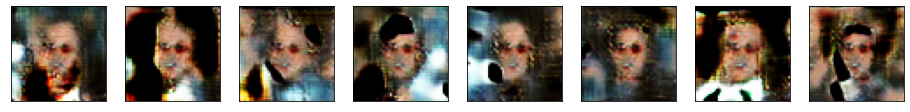

[Step 7000] D Loss: 0.1737; G Loss: 4.1128


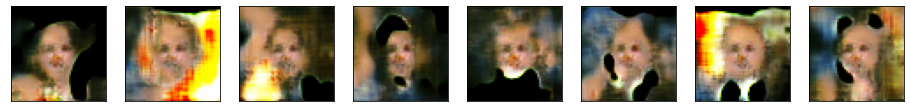

[Step 7200] D Loss: 0.1766; G Loss: 6.2585


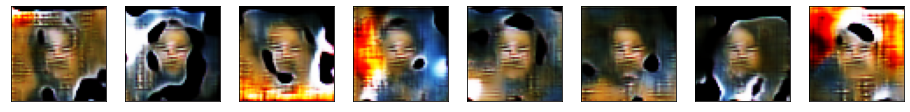

[Step 7400] D Loss: 0.2306; G Loss: 3.1542


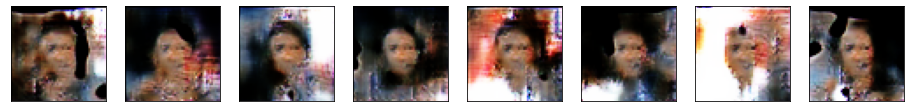

[Step 7600] D Loss: 0.2065; G Loss: 9.0247


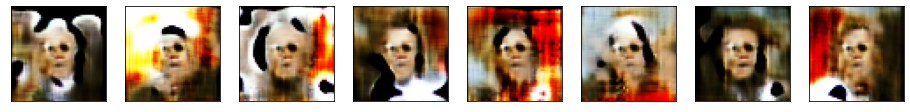

[Step 7800] D Loss: 0.0308; G Loss: 7.8252


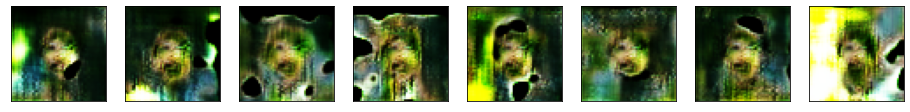

[Step 8000] D Loss: 0.0199; G Loss: 7.4192


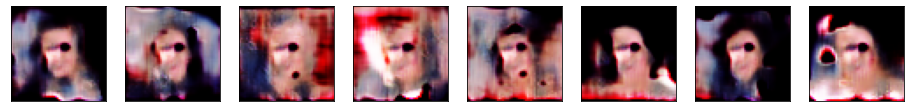

[Step 8200] D Loss: 0.0969; G Loss: 7.3187


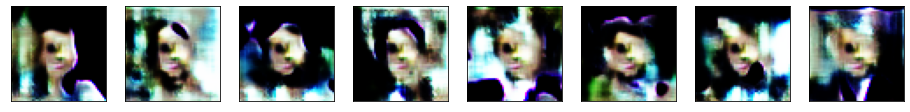

Wall time: 6h 1min 28s


In [105]:
%%time
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)

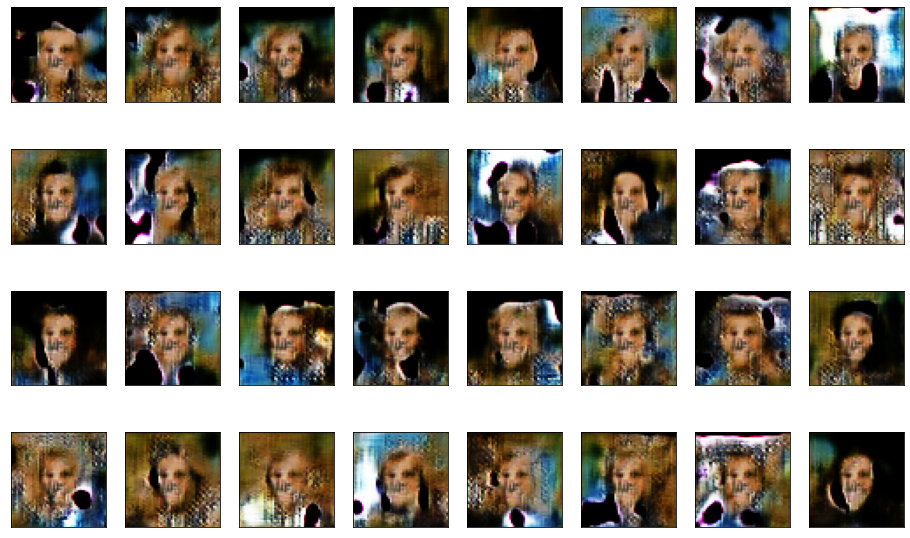

In [106]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)